<a href="https://colab.research.google.com/github/VMBoehm/DeNoPa/blob/master/TestingNVPExtensionGaussianLikelihoodTestingVI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
! pip install -q https://github.com/dfm/corner.py/archive/master.zip

     - 10.8MB 2.5MB/s


In [0]:
import corner

In [4]:
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow_hub as hub
tfd = tfp.distributions
tfb = tfp.bijectors
IMAGE_SHAPE = [28, 28, 1]

W0507 17:20:34.719146 140506958735232 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [9]:
generator_path = './gdrive/My Drive/MPM/modules/vae1/vae_1/decoder'
encoder_path   ='./gdrive/My Drive/MPM/modules/gauss3b/gauss3b-final/encoder'
nvp_func_path      = './gdrive/My Drive/MPM/modules/gauss3b/nvp-final4'
minima_path      = './gdrive/My Drive/MPM/modules/gauss3b/minima/'
!ls ./gdrive/My\ Drive/MPM/modules/gauss3b/nvp-final4/

assets	saved_model.pb	tfhub_module.pb  variables


In [0]:
import gzip, zipfile, tarfile
import os, shutil, re, string, urllib, fnmatch
import pickle as pkl

def _download_mnist_realval(dataset):
    """
    Download the MNIST dataset if it is not present.
    :return: The train, test and validation set.
    """
    origin = (
        'http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz'
    )
    print('Downloading data from %s' % origin)
    urllib.request.urlretrieve(origin, dataset)

def _get_datafolder_path():
    full_path = os.path.abspath('.')
    path = full_path +'/data'
    return path

def load_mnist_realval(
        dataset=_get_datafolder_path()+'/mnist_real/mnist.pkl.gz'):
    '''
    Loads the real valued MNIST dataset
    :param dataset: path to dataset file
    :return: None
    '''
    if not os.path.isfile(dataset):
        datasetfolder = os.path.dirname(dataset)
        if not os.path.exists(datasetfolder):
            os.makedirs(datasetfolder)
        _download_mnist_realval(dataset)

    f = gzip.open(dataset, 'rb')
    train_set, valid_set, test_set = pkl.load(f, encoding='latin1')
    f.close()
    x_train, targets_train = train_set[0], train_set[1]
    x_valid, targets_valid = valid_set[0], valid_set[1]
    x_test, targets_test = test_set[0], test_set[1]
    return x_train, targets_train, x_valid, targets_valid, x_test, targets_test

In [0]:
x_train, targets_train, x_valid, targets_valid, x_test, targets_test = load_mnist_realval()

In [12]:
#finding EL2O 'by hand'
tf.reset_default_graph()

sigma_n=0.1
batch_size2 = 64
hidden_size = 10
lr            = tf.placeholder_with_default(0.001,shape=[])
generator     = hub.Module(generator_path, trainable=False)

optimizer     = tf.train.AdamOptimizer(learning_rate=lr)

prior = tfd.MultivariateNormalDiag(tf.zeros(hidden_size), scale_identity_multiplier=1.0)

# get some masked data
x_corr            = tf.placeholder(shape=[batch_size2,784,1], dtype=tf.float32)
mymask            = tf.placeholder_with_default(np.ones((784),dtype=int),shape=[784])
m_data            = tf.boolean_mask(x_corr, mymask, axis=1)

with tf.variable_scope("posterior_elbo"):
  mu_elbo      = tf.Variable(np.zeros((batch_size2,hidden_size)), dtype=np.float32)
  sigma_elbo   = tf.Variable(np.ones((batch_size2,hidden_size)), dtype=np.float32)

approx_posterior_elbo = tfd.MultivariateNormalDiag(loc=mu_elbo,scale_diag=sigma_elbo, name='approxposterior_elbo')
zz_               = approx_posterior_elbo.sample()
elbo_mean         = approx_posterior_elbo.mean()
kl_divergence2    = tfd.kl_divergence(approx_posterior_elbo, prior) 
elbo_liklogits    = tf.boolean_mask(tf.reshape(generator(zz_),[-1,784,1]), mymask, axis=1)
data_likelihood2  = tfd.Independent(tfd.Bernoulli(logits=elbo_liklogits))#tfd.Independent(tfd.MultivariateNormalDiag(loc=elbo_liklogits,scale_identity_multiplier=sigma_n))#
elbo2             = -tf.reduce_mean(data_likelihood2.log_prob(x_corr)- kl_divergence2,axis=0)

opt_op_elbo2      = optimizer.minimize(elbo2,var_list=[mu_elbo,sigma_elbo])

# batch_size    = 64#512
# batch_size_2  = 1
# hidden_size   = 10
# sample_size_z = 64
# sigma_n       = 0.1
# n_channels    = 1
# # num_comp      = 10

# # nvp_size      = [[512, 512], [512, 512], [512, 512],[512, 512], [512, 512],[512, 512]]
# # nvp_prior     = tf.placeholder_with_default(True,shape=[])
# # true_hess     = tf.placeholder_with_default(True,shape=[])



# #sample_size_x = tf.placeholder_with_default(10,shape=[])
# lr            = tf.placeholder_with_default(0.001,shape=[])

# optimizer     = tf.train.AdamOptimizer(learning_rate=lr)

# generator = hub.Module(generator_path, trainable=False)
# #encoder   = hub.Module(encoder_path, trainable=False)
# #nvp_funcs = hub.Module(nvp_func_path, trainable=False)

# # Define latent space prior
# prior             = tfd.MultivariateNormalDiag(loc=tf.zeros([hidden_size]),scale_identity_multiplier=1.0)
# #log_det_prior     = tf.linalg.logdet(prior.covariance())

# # data
# # A) training set (used to train maf/should not be corrupted)
# #x_tr              = tf.placeholder(shape=[batch_size,784,n_channels], dtype=tf.float32)

# #prior_sample      = tf.placeholder(shape=[sample_size_z,hidden_size], dtype=tf.float32)

# # this is the noise of the corrupted data
# #sigma_corr        = tf.placeholder_with_default(np.ones([batch_size_2,784,n_channels], dtype='float32')*sigma_n,shape=[batch_size_2,784,n_channels])


# # # vae does mean field approximation
# # encoded_data      = encoder(tf.reshape(x_tr,[-1,28,28,n_channels]))
# # mu, sigma         = tf.split(encoded_data, 2, axis=-1)
# # sigma             = tf.nn.softplus(sigma) + 0.0001
# # approx_posterior  = tfd.MultivariateNormalDiag(loc=mu, scale_diag=sigma)

# # vae_liklogits     = tf.reshape(generator(mu),[batch_size,784,1])

# # # uncoruppted data likelihood
# # likelihood_vae    = tfd.Independent(tfd.MultivariateNormalDiag(loc=vae_liklogits,scale_identity_multiplier=sigma_n))
# # recon             = likelihood_vae.mean()

# # # test saple from prior
# prior_samples     = prior.sample(sample_size_z)
# sample_liklogits  = tf.reshape(generator(prior_samples),[-1,784,n_channels])

# sample_mean       = tfd.Independent(tfd.Bernoulli(logits=sample_liklogits)).mean()
# sample_likelihood = tfd.Independent(tfd.MultivariateNormalDiag(loc=sample_liklogits,scale_identity_multiplier=sigma_n))
# sample_mean       = sample_likelihood.mean()






### ---- training the nvp ----- ###

# def get_nvp():
  
#   p1 = np.arange(0,hidden_size//2)
#   p2 = np.arange(hidden_size//2,hidden_size)
#   perm=np.concatenate((p2,p1))
  
#   base_dis = tfd.MultivariateNormalDiag(loc=np.zeros(hidden_size, dtype='float32'),scale_identity_multiplier=1.0,name='base_dis')
  
#   chain = []
  
#   for i,s in enumerate(nvp_size):
#     chain.append(tfb.RealNVP(num_masked=5,shift_and_log_scale_fn=tfb.real_nvp_default_template(hidden_layers=s,name='nvp%d'%i)))
#     chain.append(tfb.Permute(permutation=perm,name='perm%d'%i))

#   nvp = tfd.TransformedDistribution(distribution=base_dis,bijector=tfb.Chain(chain),name='mynvp')
                 
#   return nvp

# def nvp_module_spec():
#     z_sample     = tf.placeholder(tf.float32, shape=[None,hidden_size])
#     sample_size  = tf.placeholder(tf.int32, shape=[])
#     u_sample     = tf.placeholder(tf.float32, shape=[None,hidden_size])
#     nvp_         = get_nvp()
#     log_prob     = nvp_.log_prob(z_sample)
#     nvp_sample   = nvp_.sample(sample_size)
#     nvp_fwd_pass = nvp_.bijector.forward(u_sample)
#     hub.add_signature(inputs={'z_sample':z_sample,'sample_size':sample_size, 'u_sample':u_sample},outputs={'log_prob':log_prob, 'sample':nvp_sample, 'fwd_pass': nvp_fwd_pass})

# nvp_spec  = hub.create_module_spec(nvp_module_spec)
# nvp_funcs = hub.Module(nvp_spec, name='nvp_funcs',trainable=True)

# nvp       = get_nvp()
# loss      = -tf.reduce_mean(nvp_funcs({'z_sample':approx_posterior.sample(),'sample_size':1, 'u_sample':np.zeros((1,hidden_size))},as_dict=True)['log_prob'])
# optimizer = tf.train.AdamOptimizer(learning_rate=lr)
# opt_op    = optimizer.minimize(loss)

### ---- training the nvp ----- ###





# # B) corrupted data from test set (networks should not have seen this before)
# x_re                 = tf.placeholder(shape=[batch_size_2,784,n_channels], dtype=tf.float32)

# # ### doing VI on this new posterior
# with tf.variable_scope("posterior_elbo"):
#   mu_elbo      = tf.Variable(np.zeros((batch_size_2,hidden_size)), dtype=np.float32)
#   sigma_elbo   = tf.Variable(np.ones((batch_size_2,hidden_size)), dtype=np.float32)

  

# # #update4               = tf.stop_gradient(mu_elbo.assign(MAP))
# # #start with mean field
# approx_posterior_elbo = tfd.MultivariateNormalDiag(loc=mu_elbo,scale_diag=sigma_elbo, name='approxposterior_elbo')

# zz_                   = approx_posterior_elbo.sample()
# #fwd_zz                = nvp_funcs({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':zz_},as_dict=True)['fwd_pass']

# # option to use uncorrected latent space
# gen_zz                = tf.reshape(generator(zz_),[batch_size_2,784,n_channels])

# likeli_zz             = tfd.Independent(tfd.Bernoulli(logits=gen_zz)).log_prob(x_re)#tfd.Independent(tfd.Normal(loc=gen_zz,scale=sigma_corr)).log_prob(x_re)
# kl_divergence_elbo    = tfd.kl_divergence(approx_posterior_elbo, prior) 

# elbo2                 = -tf.reduce_mean(likeli_zz- kl_divergence_elbo,axis=0)
# opt_op3               = optimizer.minimize(elbo2, var_list=[mu_elbo,sigma_elbo])

# prior_zz              = prior.log_prob(zz_)

# posterior_zz          = likeli_zz+prior_zz

# elbo2                 = -tf.reduce_mean(approx_posterior_elbo.log_prob(zz_)-posterior_zz)


# #### for naive recon and strating MAP finding at truth

# ### for corrupted data, we need different batch size:
# encoded_data_c    = encoder(tf.reshape(x_re,[-1,28,28,n_channels]))
# mu_c, sigma_c     = tf.split(encoded_data_c, 2, axis=-1)

# # # coruppted data likelihood
# corr_liklogits    = tf.reshape(generator(mu_c),[batch_size_2,784,n_channels])
# likelihood_corr   = tfd.Independent(tfd.MultivariateNormalDiag(loc=corr_liklogits,scale_identity_multiplier=sigma_corr))
# corr_recon        = likelihood_vae.mean()

# ### estimate the MAP for ###
# MAP_ini              = tf.placeholder_with_default(tf.zeros([batch_size_2,hidden_size]),shape=[batch_size_2,hidden_size])
# MAP                  = tf.Variable(MAP_ini)

# MAP_reset            = tf.stop_gradient(MAP.assign(MAP_ini))

# fwd_MAP              = nvp_funcs({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':MAP},as_dict=True)['fwd_pass']

# # option to use uncorrected latent space
# genMAP               = tf.reshape(tf.cond(nvp_prior, lambda: generator(fwd_MAP), lambda: generator(MAP)),[batch_size_2,784,n_channels])

# likeli_MAP           = tfd.Independent(tfd.Normal(loc=genMAP,scale=sigma_corr)).log_prob(x_re)

# prior_MAP            = prior.log_prob(MAP)

# posterior_MAP        = prior_MAP+likeli_MAP

# loss_MAP             = -tf.reduce_mean(posterior_MAP)

# opt_op2              = optimizer.minimize(loss_MAP, var_list=[MAP])

# MAP_mean             = tfd.Independent(tfd.Normal(loc=genMAP,scale=sigma_corr)).mean()


# ##### do Laplace approximation
# ini_val  = np.ones((batch_size_2,(hidden_size *(hidden_size +1)) // 2),dtype=np.float32)

# with tf.variable_scope("approxposterior",reuse=tf.AUTO_REUSE):
#   mu_new      = tf.Variable(np.ones((batch_size_2,hidden_size),dtype=np.float32), dtype=np.float32)
#   sigma_new_t = ini_val
#   sigma_new_t2= tf.Variable(tfd.matrix_diag_transform(tfd.fill_triangular(sigma_new_t), transform=tf.nn.softplus))
  
# approx_posterior_laplace = tfd.MultivariateNormalTriL(loc=mu_new,scale_tril=sigma_new_t2)


# update2          = tf.stop_gradient(mu_new.assign(MAP))

# # this is exact hessian computation 
# hess             = tf.hessians(-posterior_MAP,MAP)
# hess             = tf.gather(hess, 0)
# hess2            = tf.reduce_sum(hess, axis = 2 )

# #constructing Hessian from known analytic form of posterior (this is for Gaussian likelihood+prior with unit variance)

# grad_g           = tf.gather(tf.gradients(genMAP/(sigma_corr),MAP),0)

# grad_g2          = tf.einsum('ij,ik->ijk',grad_g,grad_g)

# one              = tf.linalg.eye(hidden_size, batch_shape=[batch_size_2],dtype=tf.float32)

# hess_approx      = one+grad_g2

# eig1             = tf.cond(true_hess, lambda: tf.linalg.eigvalsh(hess2), lambda: tf.linalg.eigvalsh(hess_approx))

# sigma_hess       = tf.cond(true_hess, lambda: tf.linalg.inv(hess2), lambda: tf.linalg.inv(hess_approx))

# sigma_hess       = 0.5*(sigma_hess+tf.linalg.transpose(sigma_hess))

# eig2             = tf.linalg.eigvalsh(sigma_hess)

# update3          = sigma_new_t2.assign(tf.linalg.cholesky(sigma_hess))

# update3b         = sigma_new_t2.assign(tf.linalg.cholesky(one))

# lap_z_samples    = tf.reshape(approx_posterior_laplace.sample(sample_size_z),[-1,hidden_size])
# lap_liklogits    = tf.reshape(generator(lap_z_samples),[-1,784,n_channels])
# lap_likelihood   = tfd.Independent(tfd.Normal(loc=lap_liklogits,scale=sigma_corr))
# lap_mean         = lap_likelihood.mean()
# lapl_variance_MAP= tf.linalg.diag_part(approx_posterior_laplace.covariance())


# ### doing VI on this new posterior
# with tf.variable_scope("posterior_elbo"):
#   mu_elbo      = tf.Variable(np.zeros((batch_size_2,hidden_size)), dtype=np.float32)
#   sigma_elbo   = tf.Variable(np.ones((batch_size_2,hidden_size)), dtype=np.float32)

  

# #update4               = tf.stop_gradient(mu_elbo.assign(MAP))
# #start with mean field
# approx_posterior_elbo = tfd.MultivariateNormalDiag(loc=mu_elbo,scale_diag=sigma_elbo, name='approxposterior_elbo')

# zz_                   = approx_posterior_elbo.sample()
# #fwd_zz                = nvp_funcs({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':zz_},as_dict=True)['fwd_pass']

# # option to use uncorrected latent space
# gen_zz                = tf.reshape(generator(zz_),[batch_size_2,784,n_channels])

# likeli_zz             = tfd.Independent(tfd.Normal(loc=gen_zz,scale=sigma_corr)).log_prob(x_re)
# kl_divergence_elbo    = tfd.kl_divergence(approx_posterior_elbo, prior) 

# elbo2                 = -tf.reduce_mean(likeli_zz- kl_divergence_elbo,axis=0)

# # prior_zz              = prior.log_prob(zz_)

# # posterior_zz          = likeli_zz+prior_zz

# # elbo2                 = -tf.reduce_mean(approx_posterior_elbo.log_prob(zz_)-posterior_zz)

# opt_op3               = optimizer.minimize(elbo2, var_list=[mu_elbo,sigma_elbo])

# # # construct a GMM approximation from different minima

# with tf.variable_scope("corrupted/gmm",reuse=tf.AUTO_REUSE):
#   mu_gmm      = tf.Variable(np.ones((batch_size_2,num_comp,hidden_size)), dtype=np.float32)
#   ini_val2    = np.ones((batch_size_2,num_comp,(hidden_size *(hidden_size +1)) // 2),dtype=np.float32)
#   sigma_gmm   = tf.constant(ini_val2)
#   sigma_gmmt  = tf.Variable(tfd.matrix_diag_transform(tfd.fill_triangular(sigma_gmm), transform=tf.nn.softplus))
#   w_gmm       = tf.Variable(np.ones((num_comp))/num_comp, dtype=np.float32)

# mu_est        = tf.placeholder_with_default(tf.zeros([batch_size_2,num_comp,hidden_size]),shape=[batch_size_2,num_comp,hidden_size])
# sigma_est     = tf.placeholder_with_default(tf.ones([batch_size_2,num_comp,hidden_size, hidden_size]),shape=[batch_size_2,num_comp,hidden_size, hidden_size])
# w_est         = tf.placeholder_with_default(tf.ones([num_comp])/num_comp,shape=[num_comp])

# update_a      = w_gmm.assign(w_est)
# update_b      = mu_gmm.assign(mu_est)
# update_c      = sigma_gmmt.assign(sigma_est)

# gmm           = tfd.MixtureSameFamily(mixture_distribution=tfd.Categorical(probs=w_gmm),components_distribution=tfd.MultivariateNormalTriL(loc=mu_gmm,scale_tril=sigma_gmmt))

# gmm_sample_z  = gmm.sample(sample_size_z)
# #gmm_sample_x  = tfd.Independent(tfd.Normal(loc=tf.reshape(generator(gmm_sample_z),[-1,784,n_channels]),scale=sigma_corr)).mean()

# saver         = tf.train.Saver()

Instructions for updating:
Colocations handled automatically by placer.


W0507 17:21:01.622915 140506958735232 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/control_flow_ops.py:3632: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0507 17:21:02.560570 140506958735232 saver.py:1483] Saver not created because there are no variables in the graph to restore


Instructions for updating:
Use tf.cast instead.


W0507 17:21:02.665432 140506958735232 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


In [0]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [0]:
mask = np.ones(IMAGE_SHAPE, dtype=int)
mask[13:16,0:28]=0.
mask = mask.reshape((28*28))

masked_data = x_test[:batch_size2]*[mask]

In [0]:
posterior_loss=[]

In [16]:
lrate=1e-2
for ii in range(2000):
  _, ll = sess.run([opt_op_elbo2, elbo2],feed_dict={x_corr: np.expand_dims(masked_data,-1), lr:lrate})
  posterior_loss.append(ll)
  if ii%100==0:
    print(ll)

488.13177
212.4549
134.42822
114.96826
111.49536
109.68559
109.22139
108.40287
108.35965
107.88791
108.21085
107.6697
107.95192
107.943436
108.245674
108.16638
108.306274
108.31116
107.755646
107.986465


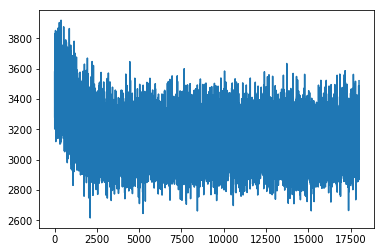

In [37]:
plt.plot(posterior_loss)

In [17]:
inc     = 0
x_truth = x_test[inc:batch_size+inc]

NameError: ignored

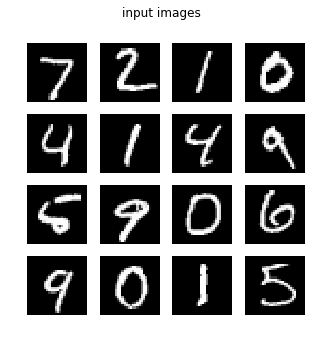

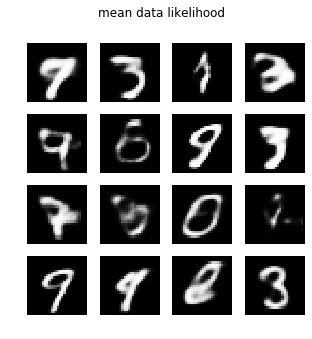

In [0]:
#samples = sess.run(prior_samples, feed_dict={x_tr: np.expand_dims(x_truth,-1)})
#samples.shape
res = sess.run(sample_mean)#, prior_sample: samples})
    
figure(figsize=(5,5))
suptitle('input images')
for i in range(min(batch_size,16)):
    subplot(4,4,i+1)
    imshow(inim[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')

figure(figsize=(5,5))
suptitle('mean data likelihood')
for i in range(min(batch_size,16)):
    subplot(4,4,i+1)
    imshow(np.reshape(res[i,:,0],(28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')

In [0]:
posterior_loss = []
ii     = 0
nepoch = 0
learning_rate = 1e-3

In [0]:
#train the nvp
while nepoch<1000:
  if (ii+1)*batch_size>len(x_train): 
    np.random.shuffle(x_train)
    ii=0
    nepoch+=1
    print('starting epoch', nepoch)
  if nepoch>100:
    learning_rate=1e-4
  if nepoch>200:
    learning_rate=1e-6
  x_truth = x_train[batch_size*ii:batch_size*(ii+1)]
  _, ll = sess.run([opt_op,loss], feed_dict={x_tr: np.expand_dims(x_truth,-1), lr: learning_rate})
  posterior_loss+=[ll]
  if ii%500==0:
    print(ll)
  ii+=1

starting epoch 820
7.26298
starting epoch 821
7.3390646
starting epoch 822
7.6767645
starting epoch 823
7.403802
starting epoch 824
7.3611774
starting epoch 825
7.216843
starting epoch 826
7.395504
starting epoch 827
7.451064
starting epoch 828
7.3928185
starting epoch 829
7.389846
starting epoch 830
7.293434
starting epoch 831
7.270045
starting epoch 832
7.4543786
starting epoch 833
7.496449
starting epoch 834
7.2095222
starting epoch 835
7.4845066
starting epoch 836
7.311516
starting epoch 837
7.1459236
starting epoch 838
7.594301
starting epoch 839
7.3255105
starting epoch 840
7.4092646
starting epoch 841
7.286358
starting epoch 842
7.217915
starting epoch 843
7.374605
starting epoch 844
7.5429273
starting epoch 845
7.5740943
starting epoch 846
7.336297
starting epoch 847
7.2174478
starting epoch 848
7.2173376
starting epoch 849
7.644237
starting epoch 850
7.4684052
starting epoch 851
7.250959
starting epoch 852
7.484912
starting epoch 853
7.33707
starting epoch 854
7.5505853
starti

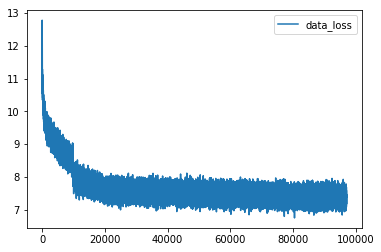

In [0]:
plt.figure()
plot(posterior_loss[::],label='data_loss')
legend()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0507 04:21:22.948374 139868462983040 saver.py:1483] Saver not created because there are no variables in the graph to restore


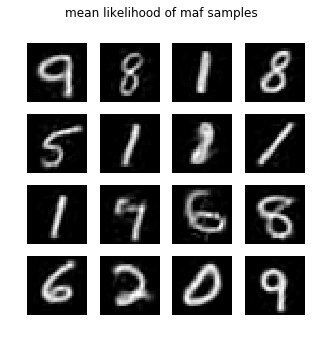

In [0]:
samples1 = sess.run(nvp_funcs({'z_sample':approx_posterior.sample(),'sample_size':sample_size_z,'u_sample':np.zeros((1, hidden_size))},as_dict=True)['sample'])

s = sess.run(sample_mean, feed_dict={prior_sample: samples1})

figure(figsize=(5,5))
suptitle('mean likelihood of maf samples')
for i in range(16):
    subplot(4,4,i+1)
    imshow(np.reshape(s[i,:,0],(28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')

In [0]:

#nvp_funcs.export(nvp_func_path,sess)


In [0]:
maf_s, prior_s = sess.run([nvp_funcs({'z_sample':approx_posterior.sample(),'sample_size':10000,'u_sample':np.zeros((1, hidden_size))},as_dict=True)['sample'], prior.sample(10000)])
print(maf_s.shape)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0505 18:29:45.170338 140256009533312 saver.py:1483] Saver not created because there are no variables in the graph to restore


(10000, 10)


/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


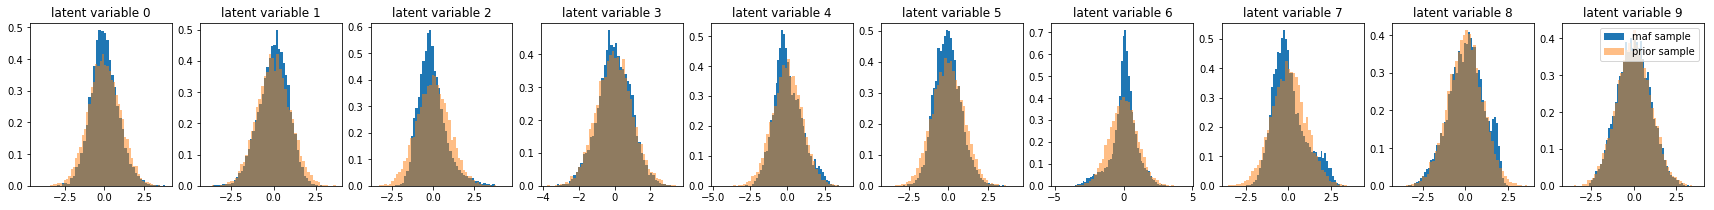

In [0]:
f=plt.figure()
f.set_figheight(3)
f.set_figwidth(30)
for ii in range(hidden_size):
  subplot(1,hidden_size,ii+1)
  plt.title('latent variable %d'%ii)
  _=plt.hist(maf_s[:,ii],bins=50, label='maf sample',normed=True)
  _=plt.hist(prior_s[:,ii],alpha=0.5,bins=50,label='prior sample',normed=True)
plt.legend()
plt.show()

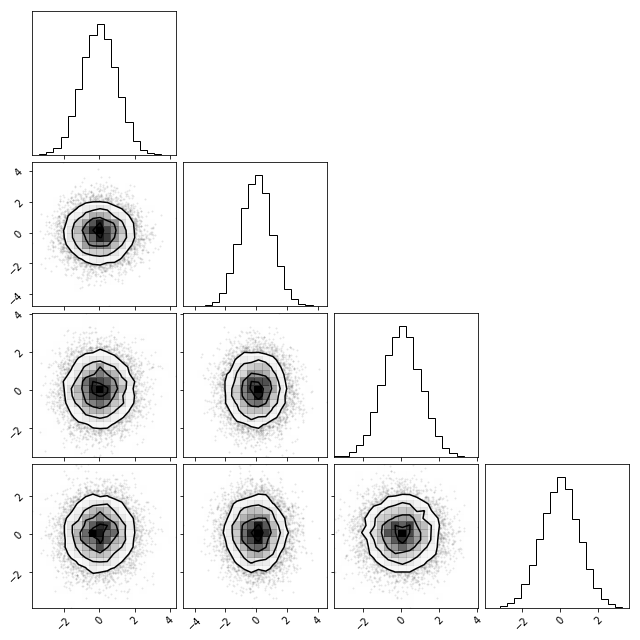

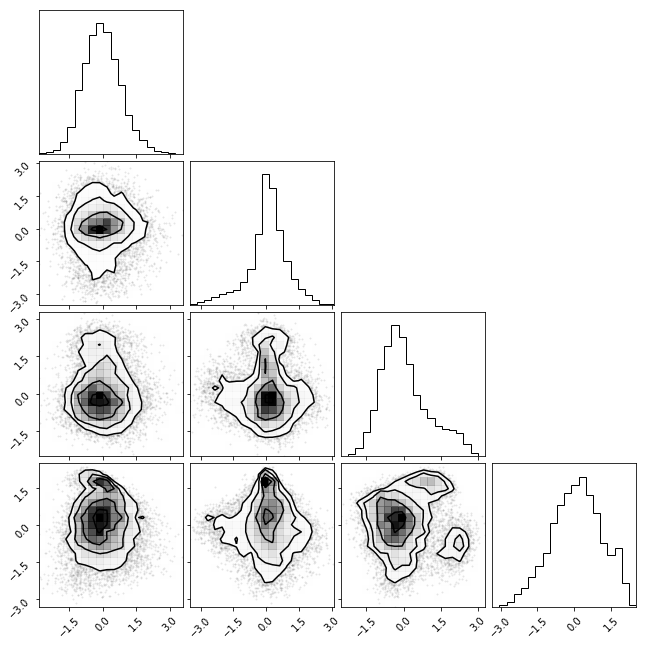

In [0]:
_ = corner.corner(prior_s[:,5:-1])
_ = corner.corner(maf_s[:,5:-1])

In [0]:
inc = 6
x_truth   = x_test[inc:batch_size_2+inc]
sigma_new = np.ones([28,28])*sigma_n
sigma_new[0:28,12:18]=1e8
mask=np.ones([28,28])
mask[np.where(sigma_new==1e8)]=0

data        = np.expand_dims(x_truth,-1)
sigma_new   = sigma_new.reshape([batch_size_2,784,n_channels])
mask        = mask.reshape([batch_size_2,784,n_channels])
data        = data*mask

In [0]:
learning_rate = 1e-5
#_ = sess.run(MAP_reset,feed_dict={x_re: data, MAP_ini:map_minima[0][0], sigma_corr:sigma_new})
#sess.run(update4,feed_dict={x_re: data, sigma_corr:sigma_new, lr:learning_rate})
for ii in range(100):
  _, ll = sess.run([opt_op3,elbo2],feed_dict={x_re: data, lr:learning_rate})
  print(ll)

351.50983
454.9313
367.39197
712.3529
447.5282
548.48914
688.9073
420.83984
476.93417
568.95154
475.24542
285.90463
433.06577
371.01013
590.2084
968.19275
477.37622
625.343
405.8537
267.56024
425.82602
235.24591
527.96655
828.04266
339.7022
680.6256
716.4505
1110.4442
344.15833
394.2843
453.962
385.7228
329.35678
462.88504
285.22726
432.67862
418.5237
535.3446
534.56085
249.21753
352.8823
240.95468
354.58008
487.63367
634.51404
519.18835
419.90543
532.78644
361.1094
569.1432
302.86624
336.5729
436.53738
961.4212
260.38474
550.0579
274.47214
368.86145
547.6412
418.07312
545.44434
255.17638
721.4761
390.00806
452.37643
300.99103
365.10626
443.40952
568.44604
208.66039
250.64667
331.40295
388.36844
549.25366
788.5308
393.92368
408.5338
308.44394
266.38345
463.29352
620.6511
527.6023
319.31183
431.75842
362.1862
326.71912
540.5989
304.68008
287.95667
753.50745
238.64105
652.99695
311.5202
618.18884
722.2153
703.45935
494.203
275.93988
260.2749
496.5127


0
4152.7983
2673.31
2671.082
2677.8389
2672.2776
2678.66
2669.5505
2670.4832
2673.9321
2670.4556
2676.3167
2671.8423
2673.8105
2701.7705
2673.0527
2671.4392
2672.1992
2697.466
2671.5164
2671.444
switching to lr 0.01
2671.4521
2671.4368
2671.4373
2671.4407
2671.4395
2671.4507
2671.4492
2671.4407
2671.4873
2671.4446
switching to lr 0.001
2671.4893
2671.4836
2671.486
2671.4868
2671.4846
1
3811.0864
3095.0571
3063.1526
3071.8196
3063.984
3072.296
3064.5674
3004.3953
3019.1252
2676.0906
2685.5713
2675.0938
2671.63
2671.5146
2671.5142
2758.0068
2675.3145
2671.467
2677.052
2672.0984
switching to lr 0.01
2673.5447
2671.8281
2671.8032
2671.4424
2671.437
2671.4429
2671.4453
2671.505
2671.455
2671.4858
switching to lr 0.001
2671.47
2671.4324
2671.433
2671.433
2671.4343
2
4399.7935
2671.2822
2671.9912
2674.0322
2671.5098
2686.3606
2687.3137
2686.434
2673.633
2672.242
2670.6033
2675.6963
2673.1025
2671.65
2671.1304
2671.8872
2673.0723
2673.5132
2673.4294
2672.5903
switching to lr 0.01
2671.5002
266

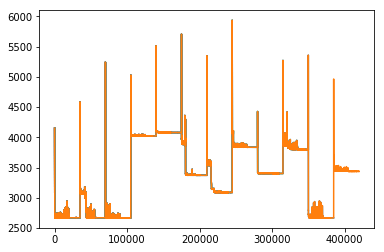

In [0]:
posterior_loss2=[]

l_minima=[]
map_minima=[]
for ii in range(12):
  print(ii)
  if ii ==1:
    ini = np.zeros((batch_size_2*hidden_size)).reshape((batch_size_2,hidden_size))
  elif ii==0:
    #starting from truth
    ini = sess.run([mu_c],feed_dict={x_re: np.expand_dims(x_truth,-1), sigma_corr:sigma_new})[0]
  else:
    ini = np.random.randn((batch_size_2*hidden_size)).reshape((batch_size_2,hidden_size))
  sess.run(MAP_reset,feed_dict={x_re: data, MAP_ini:ini, sigma_corr:sigma_new})
  lrate=1e-1
  for ii in range(20000):
    _, ll = sess.run([opt_op2,loss_MAP],feed_dict={x_re: data, sigma_corr:sigma_new, lr: lrate})
    posterior_loss2.append(ll)
    if ii%1000==0:
      print(ll)
  lrate=1e-2
  print('switching to lr', lrate)
  for ii in range(10000):
    _, ll = sess.run([opt_op2,loss_MAP],feed_dict={x_re: data, sigma_corr:sigma_new, lr: lrate})
    posterior_loss2.append(ll)
    if ii%1000==0:
      print(ll)
  lrate=1e-3
  print('switching to lr', lrate)
  for ii in range(5000):
    _, ll = sess.run([opt_op2,loss_MAP],feed_dict={x_re: data, sigma_corr:sigma_new, lr: lrate})
    posterior_loss2.append(ll)
    if ii%1000==0:
      print(ll)
  plot(posterior_loss2,label='data_loss')
  l_minima+=[ll]
  map_minima+=[sess.run([MAP],feed_dict={x_re: data, sigma_corr:sigma_new})]

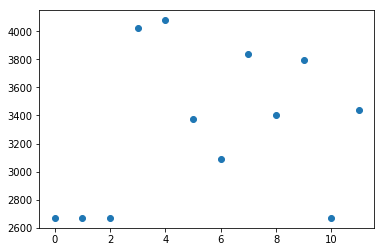

In [0]:
plt.figure()
plt.plot(np.arange(12),l_minima,ls='',marker='o')
plt.show()

In [0]:
import pickle
#pickle.dump([l_minima,map_minima],open(minima_path+'nvp_minima.pkl','wb'))
l_minima,map_minima = pickle.load(open(minima_path+'nvp_minima.pkl','rb'))

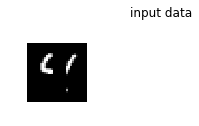

[10  2  1  0  6  5  8 11  9  7  3  4]


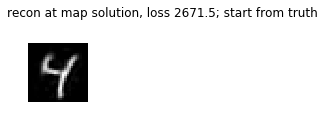

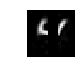

eigenvalues before and after inverse, approx hessian
[array([[9.7980565e-01, 9.9933475e-01, 9.9973267e-01, 9.9998176e-01,
        9.9999893e-01, 1.0000037e+00, 1.0001422e+00, 1.0021614e+00,
        1.0030313e+00, 3.1893175e+05]], dtype=float32), array([[3.0398369e-06, 9.9695092e-01, 9.9824864e-01, 9.9972022e-01,
        9.9993521e-01, 1.0000008e+00, 1.0000050e+00, 1.0001888e+00,
        1.0005685e+00, 1.0053730e+00]], dtype=float32)]


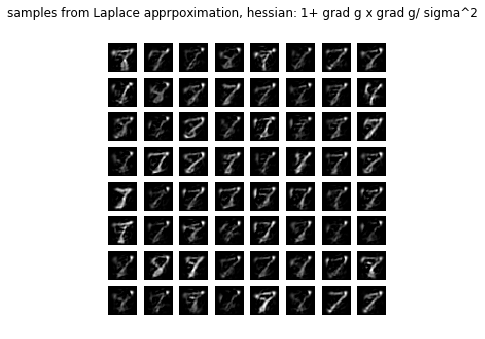

eigenvalues before and after inverse, full hessian
[array([[-9.2669764e+00, -4.8410654e+00,  4.0887556e+00,  3.0605618e+01,
         4.6358368e+01,  2.2569226e+02,  5.3957391e+02,  9.1933289e+02,
         9.6311169e+02,  3.5227293e+04]], dtype=float32), array([[-2.0655978e-01, -1.0790832e-01,  2.8385528e-05,  1.0383156e-03,
         1.0877613e-03,  1.8533210e-03,  4.4308137e-03,  2.1571008e-02,
         3.2673921e-02,  2.4458545e-01]], dtype=float32)]
full hessian fails


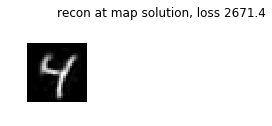

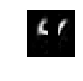

eigenvalues before and after inverse, approx hessian
[array([[9.9410766e-01, 9.9974591e-01, 9.9981421e-01, 9.9998844e-01,
        9.9999952e-01, 1.0000180e+00, 1.0000914e+00, 1.0010613e+00,
        1.0343529e+00, 3.2294675e+05]], dtype=float32), array([[2.9802318e-06, 9.9453115e-01, 9.9836791e-01, 9.9992031e-01,
        9.9995756e-01, 1.0000020e+00, 1.0000032e+00, 1.0001184e+00,
        1.0002395e+00, 1.0075605e+00]], dtype=float32)]


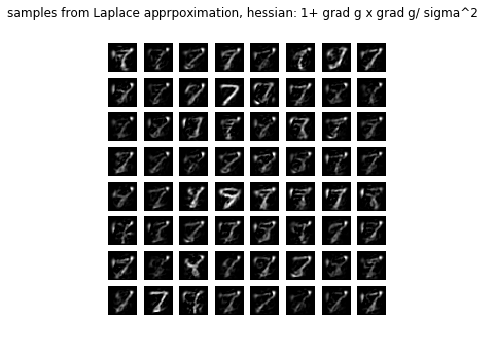

eigenvalues before and after inverse, full hessian
[array([[-8.0614939e+00, -4.6362295e+00,  5.3855009e+00,  3.0759964e+01,
         4.1463585e+01,  2.3846590e+02,  5.3436816e+02,  8.6970569e+02,
         1.0737307e+03,  3.8085805e+04]], dtype=float32), array([[-2.1571040e-01, -1.2402423e-01,  2.6262904e-05,  9.3132112e-04,
         1.1498103e-03,  1.8713608e-03,  4.1934722e-03,  2.4117216e-02,
         3.2509666e-02,  1.8568224e-01]], dtype=float32)]
full hessian fails


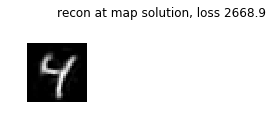

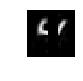

eigenvalues before and after inverse, approx hessian
[array([[9.9417067e-01, 9.9917203e-01, 9.9981564e-01, 9.9997461e-01,
        1.0000006e+00, 1.0000309e+00, 1.0001589e+00, 1.0002397e+00,
        1.0006518e+00, 1.7945708e+05]], dtype=float32), array([[5.6028366e-06, 9.9919724e-01, 9.9981558e-01, 9.9990809e-01,
        9.9996334e-01, 1.0000004e+00, 1.0000185e+00, 1.0003324e+00,
        1.0006138e+00, 1.0018489e+00]], dtype=float32)]


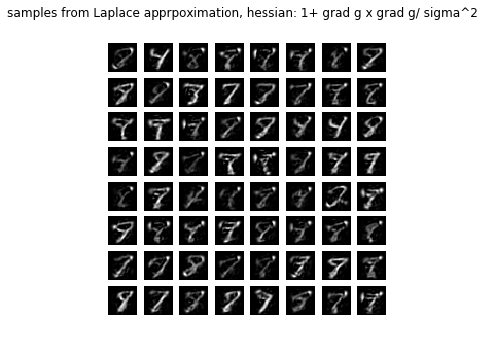

eigenvalues before and after inverse, full hessian
[array([[2.5240815e+00, 9.0774527e+00, 1.0756427e+01, 1.4348567e+01,
        3.2963051e+01, 2.1861720e+02, 3.7059338e+02, 8.8984833e+02,
        3.4593286e+03, 2.0445715e+04]], dtype=float32), array([[4.88814621e-05, 2.89081014e-04, 1.12378085e-03, 2.69836606e-03,
        4.57420899e-03, 3.03369593e-02, 6.96940646e-02, 9.29684713e-02,
        1.10157825e-01, 3.96185815e-01]], dtype=float32)]


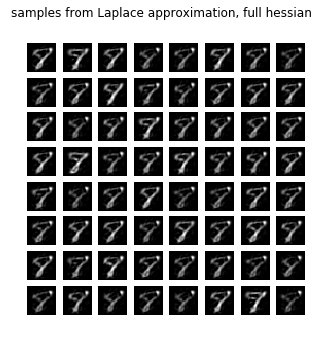

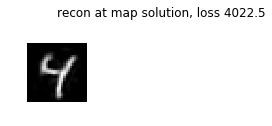

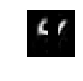

eigenvalues before and after inverse, approx hessian
[array([[9.9302983e-01, 9.9948299e-01, 9.9971867e-01, 1.0000019e+00,
        1.0000035e+00, 1.0001194e+00, 1.0001556e+00, 1.0003880e+00,
        1.0016012e+00, 1.6833684e+05]], dtype=float32), array([[5.8412552e-06, 9.9766141e-01, 9.9847686e-01, 9.9988359e-01,
        9.9992782e-01, 9.9997973e-01, 1.0000085e+00, 1.0001074e+00,
        1.0004749e+00, 1.0015175e+00]], dtype=float32)]


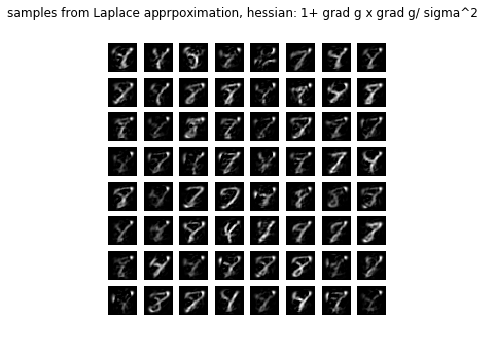

eigenvalues before and after inverse, full hessian
[array([[2.3484819e+00, 1.0382021e+01, 1.1178006e+01, 1.3229250e+01,
        3.4178394e+01, 2.3123138e+02, 3.1725226e+02, 9.3044257e+02,
        3.4276099e+03, 2.0832707e+04]], dtype=float32), array([[4.7977162e-05, 2.9175213e-04, 1.0747416e-03, 3.1520580e-03,
        4.3246783e-03, 2.9258316e-02, 7.5588852e-02, 8.9458801e-02,
        9.6326075e-02, 4.2584348e-01]], dtype=float32)]


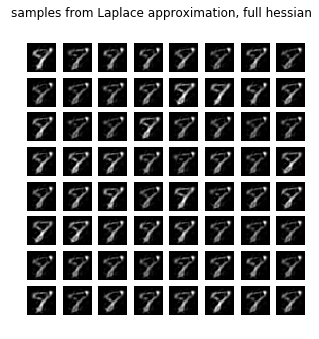

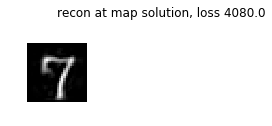

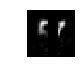

eigenvalues before and after inverse, approx hessian
[array([[9.9809819e-01, 9.9970716e-01, 9.9980688e-01, 9.9997252e-01,
        9.9999964e-01, 1.0000175e+00, 1.0001491e+00, 1.0003437e+00,
        1.0048087e+00, 6.4611195e+04]], dtype=float32), array([[1.5497208e-05, 9.9898416e-01, 9.9973691e-01, 9.9992782e-01,
        9.9997222e-01, 9.9999279e-01, 1.0000004e+00, 1.0000846e+00,
        1.0003543e+00, 1.0006896e+00]], dtype=float32)]


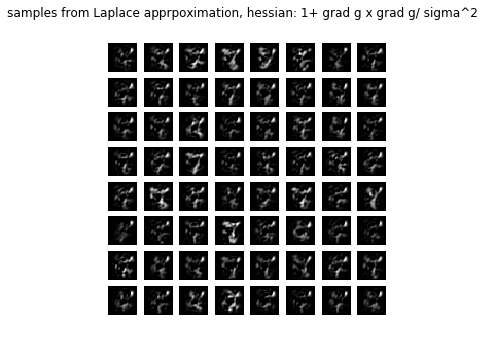

eigenvalues before and after inverse, full hessian
[array([[-4.9883080e+00,  2.7576349e+00,  4.2437835e+00,  8.3855410e+00,
         1.1447163e+01,  5.2968338e+01,  1.5473552e+02,  9.9234497e+02,
         3.9363335e+03,  9.2436250e+03]], dtype=float32), array([[-2.00462848e-01,  1.08167726e-04,  2.54040526e-04,
         1.00771000e-03,  6.46264153e-03,  1.88791137e-02,
         8.73567909e-02,  1.19250990e-01,  2.35652432e-01,
         3.62625271e-01]], dtype=float32)]
full hessian fails


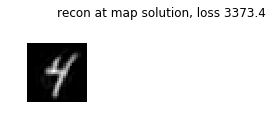

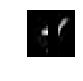

eigenvalues before and after inverse, approx hessian
[array([[9.8998475e-01, 9.9852544e-01, 9.9941754e-01, 9.9975920e-01,
        1.0000529e+00, 1.0005449e+00, 1.0007924e+00, 1.0021565e+00,
        1.0078589e+00, 3.1360050e+05]], dtype=float32), array([[3.0994415e-06, 9.9160576e-01, 9.9719375e-01, 9.9890339e-01,
        9.9962115e-01, 1.0000912e+00, 1.0002015e+00, 1.0008005e+00,
        1.0013872e+00, 1.0036235e+00]], dtype=float32)]


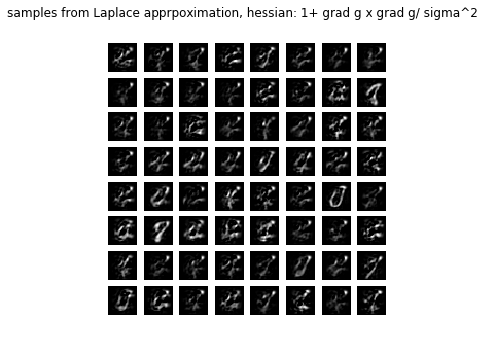

eigenvalues before and after inverse, full hessian
[array([[-4.3457761e+00,  1.8611047e+00,  2.6802096e+00,  7.8839326e+00,
         5.4043713e+01,  8.3918022e+01,  1.2937592e+02,  2.5806357e+02,
         7.7865375e+02,  1.6660854e+04]], dtype=float32), array([[-2.3007911e-01,  6.0031540e-05,  1.2842818e-03,  3.8750316e-03,
         7.7294228e-03,  1.1916396e-02,  1.8503558e-02,  1.2683608e-01,
         3.7309763e-01,  5.3732449e-01]], dtype=float32)]
full hessian fails


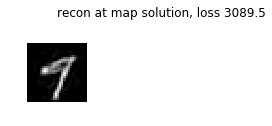

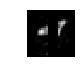

eigenvalues before and after inverse, approx hessian
[array([[9.9468505e-01, 9.9996936e-01, 9.9999511e-01, 9.9999803e-01,
        1.0000001e+00, 1.0000005e+00, 1.0000041e+00, 1.0000683e+00,
        1.0017693e+00, 4.8763500e+04]], dtype=float32), array([[2.0623207e-05, 9.9990207e-01, 9.9998027e-01, 9.9999672e-01,
        9.9999940e-01, 9.9999964e-01, 1.0000002e+00, 1.0000006e+00,
        1.0000069e+00, 1.0005853e+00]], dtype=float32)]


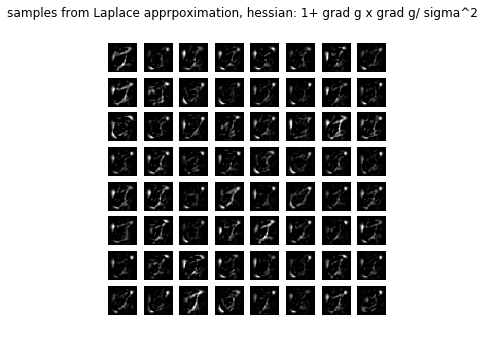

eigenvalues before and after inverse, full hessian
[array([[3.6227798e-01, 1.0060444e+00, 1.1948481e+00, 2.2696953e+00,
        3.2892206e+00, 4.4791050e+01, 2.9118909e+02, 9.5880615e+02,
        2.1377034e+03, 3.3237913e+03]], dtype=float32), array([[3.0069507e-04, 4.6777297e-04, 1.0429515e-03, 3.4341079e-03,
        2.2325967e-02, 3.0402359e-01, 4.4058928e-01, 8.3692795e-01,
        9.9399251e-01, 2.7603383e+00]], dtype=float32)]


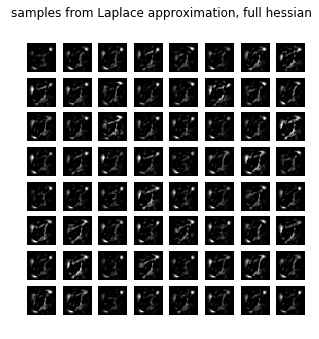

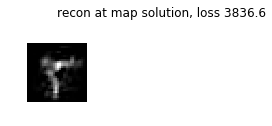

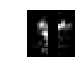

eigenvalues before and after inverse, approx hessian
[array([[9.7331756e-01, 9.9628580e-01, 9.9742889e-01, 9.9998969e-01,
        1.0000594e+00, 1.0001931e+00, 1.0011599e+00, 1.0033073e+00,
        1.0206028e+00, 6.2512000e+05]], dtype=float32), array([[1.5497208e-06, 9.9167991e-01, 9.9767298e-01, 9.9898612e-01,
        9.9955612e-01, 9.9995553e-01, 1.0000281e+00, 1.0001398e+00,
        1.0018189e+00, 1.0080109e+00]], dtype=float32)]


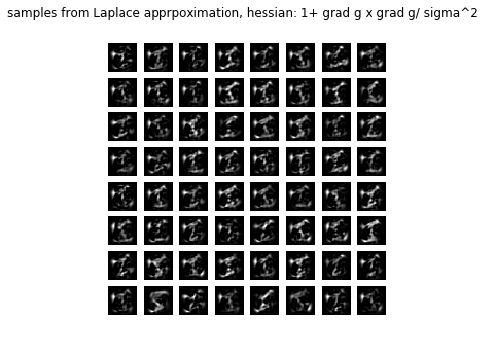

eigenvalues before and after inverse, full hessian
[array([[-2.6514015e+00,  1.6112657e+00,  9.3690624e+00,  1.8994766e+01,
         1.2438863e+02,  2.4288757e+02,  5.1964551e+02,  8.6517773e+02,
         5.4611533e+03,  1.7676285e+04]], dtype=float32), array([[-3.76837552e-01,  5.65790688e-05,  1.83109485e-04,
         1.15584361e-03,  1.92437973e-03,  4.11712052e-03,
         8.03933572e-03,  5.26434407e-02,  1.06738955e-01,
         6.20550513e-01]], dtype=float32)]
full hessian fails


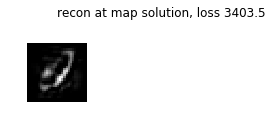

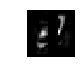

eigenvalues before and after inverse, approx hessian
[array([[9.9912983e-01, 9.9993217e-01, 9.9998897e-01, 9.9999666e-01,
        1.0000002e+00, 1.0000042e+00, 1.0000118e+00, 1.0000256e+00,
        1.0003418e+00, 2.7554803e+04]], dtype=float32), array([[3.6239624e-05, 9.9978399e-01, 9.9996132e-01, 9.9998909e-01,
        9.9999690e-01, 9.9999982e-01, 1.0000010e+00, 1.0000174e+00,
        1.0000913e+00, 1.0005556e+00]], dtype=float32)]


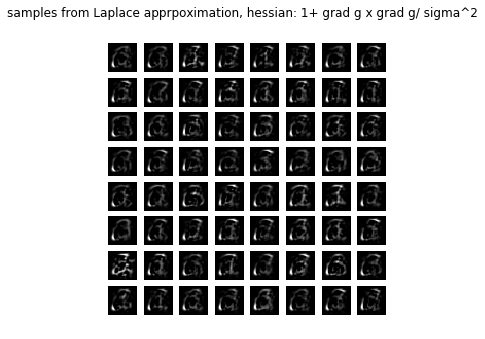

eigenvalues before and after inverse, full hessian
[array([[-7.20552504e-01,  5.79099131e+00,  7.24983168e+00,
         1.51381969e+01,  6.44172440e+01,  1.03878815e+02,
         5.09952942e+02,  6.87029846e+02,  2.42025195e+03,
         5.07799648e+04]], dtype=float32), array([[-1.3880422e+00,  1.9711269e-05,  4.1324541e-04,  1.4555635e-03,
         1.9609663e-03,  9.6265553e-03,  1.5523780e-02,  6.6056959e-02,
         1.3792925e-01,  1.7267753e-01]], dtype=float32)]
full hessian fails


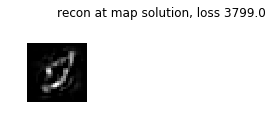

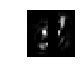

eigenvalues before and after inverse, approx hessian
[array([[9.9955416e-01, 9.9996495e-01, 9.9999177e-01, 9.9999940e-01,
        9.9999964e-01, 1.0000002e+00, 1.0000131e+00, 1.0000772e+00,
        1.0001434e+00, 1.0399408e+04]], dtype=float32), array([[9.6082687e-05, 9.9983788e-01, 9.9991047e-01, 9.9997389e-01,
        9.9999911e-01, 1.0000001e+00, 1.0000006e+00, 1.0000012e+00,
        1.0000300e+00, 1.0000955e+00]], dtype=float32)]


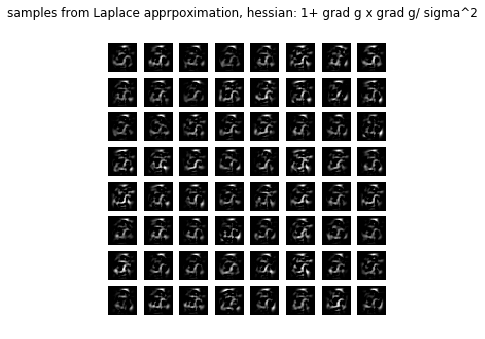

eigenvalues before and after inverse, full hessian
[array([[-1.11167383e+01, -1.81494892e+00,  2.20863962e+00,
         3.30642033e+00,  1.13787746e+01,  3.66947250e+01,
         1.13276764e+02,  6.64834717e+02,  1.17913550e+03,
         6.00113672e+03]], dtype=float32), array([[-5.5100852e-01, -8.9953952e-02,  1.6663232e-04,  8.4808021e-04,
         1.5041435e-03,  8.8279732e-03,  2.7251951e-02,  8.7882578e-02,
         3.0243367e-01,  4.5277813e-01]], dtype=float32)]
full hessian fails


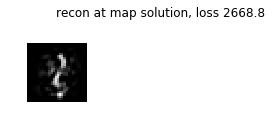

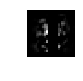

eigenvalues before and after inverse, approx hessian
[array([[9.9995393e-01, 9.9997520e-01, 9.9999774e-01, 9.9999928e-01,
        9.9999970e-01, 1.0000008e+00, 1.0000027e+00, 1.0000049e+00,
        1.0000672e+00, 2.9027805e+03]], dtype=float32), array([[3.4451485e-04, 9.9996668e-01, 9.9999452e-01, 9.9999797e-01,
        9.9999940e-01, 9.9999970e-01, 1.0000015e+00, 1.0000079e+00,
        1.0000192e+00, 1.0000362e+00]], dtype=float32)]


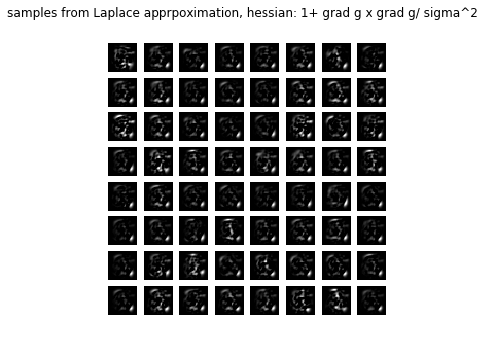

eigenvalues before and after inverse, full hessian
[array([[-1.4922799e+00,  5.1341218e-01,  2.1289158e+00,  3.5379775e+00,
         5.5205612e+00,  9.3403788e+00,  4.9276848e+01,  2.6664020e+02,
         9.9500269e+02,  6.8240410e+03]], dtype=float32), array([[-6.7005378e-01,  1.4662337e-04,  1.0050052e-03,  3.7503734e-03,
         2.0293523e-02,  1.0706227e-01,  1.8114249e-01,  2.8264970e-01,
         4.6970990e-01,  1.9478731e+00]], dtype=float32)]
full hessian fails


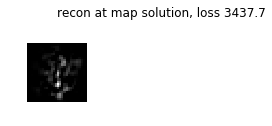

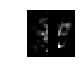

eigenvalues before and after inverse, approx hessian
[array([[  0.9999907 ,   0.99999785,   0.9999991 ,   0.99999976,
          1.        ,   1.0000001 ,   1.0000005 ,   1.0000012 ,
          1.0000075 , 196.267     ]], dtype=float32), array([[0.00509512, 0.99999636, 0.9999981 , 0.99999917, 0.99999964,
        0.9999999 , 1.0000001 , 1.0000002 , 1.0000015 , 1.0000031 ]],
      dtype=float32)]


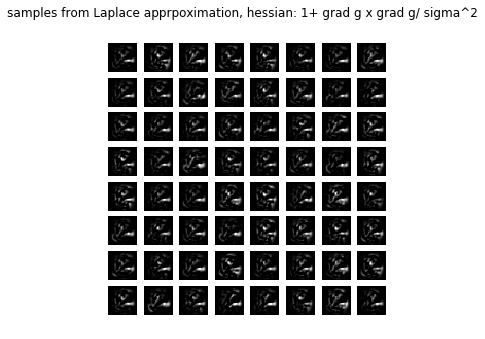

eigenvalues before and after inverse, full hessian
[array([[-18.972368  ,  -2.839077  ,  -0.74553275,   1.2435454 ,
          2.0417597 ,   2.9154596 ,   5.583815  ,  11.676694  ,
         36.89827   , 273.21704   ]], dtype=float32), array([[-1.3413146 , -0.35222793, -0.05270832,  0.00366002,  0.02710151,
         0.08564079,  0.17908922,  0.3429987 ,  0.48977494,  0.80415684]],
      dtype=float32)]
full hessian fails


In [0]:
figure(figsize=(5,5))
suptitle('input data')
for i in range(min(batch_size_2,16)):
    subplot(4,4,i+1)
    imshow(np.reshape(data[i,:],(28,28)),cmap='gray',vmin=0)
    axis('off')
plt.show()

varis=[] 
l_minima=np.asarray(l_minima)
map_minima=np.asarray(map_minima)
order = np.argsort(l_minima)
print(order)
for ii,ini_ in enumerate(map_minima[order]):
  _ = sess.run(MAP_reset,feed_dict={x_re: data, MAP_ini:ini_[0], sigma_corr:sigma_new})
  mean_at_map = sess.run(MAP_mean,feed_dict={x_re: data, sigma_corr:sigma_new})
  figure(figsize=(5,5))
  if ii==0:
    suptitle('recon at map solution, loss %.1f; start from truth'%l_minima[ii])
  else:
    suptitle('recon at map solution, loss %.1f'%l_minima[ii])
  for i in range(min(batch_size_2,16)):
      subplot(4,4,i+1)
      imshow(np.reshape(mean_at_map[i,:,0],(28,28)),cmap='gray',vmin=0)
      axis('off')
      plt.show()
      subplot(4,4,i+1)
      imshow(np.reshape(mean_at_map[i,:,0]*mask[0,:,0],(28,28)),cmap='gray',vmin=0)
      axis('off')
  plt.show()
  #constrsutcing laplace approximation
  _ = sess.run(update2,feed_dict={x_re: data, sigma_corr:sigma_new})

  _ = sess.run(update3,feed_dict={x_re: data, sigma_corr:sigma_new, true_hess:False})
  
  varis+=[sess.run(tf.linalg.diag_part(approx_posterior_laplace.covariance()),feed_dict={x_re: data, sigma_corr:sigma_new, true_hess:False})]
  print('eigenvalues before and after inverse, approx hessian')
  print(sess.run([eig1, eig2],feed_dict={x_re: data, sigma_corr:sigma_new, true_hess:False}))

  l_samples = sess.run(lap_mean,feed_dict={x_re: data, sigma_corr:sigma_new, true_hess:False})
  figure(figsize=(5,5))
  suptitle('samples from Laplace apprpoximation, hessian: 1+ grad g x grad g/ sigma^2')
  for i in range(sample_size_z):
      subplot(8,8,i+1)
      imshow(np.reshape(l_samples[i,:,0],(28,28)),cmap='gray',vmin=0)
      axis('off')
  plt.show()

  
#   _ = sess.run(update3b,feed_dict={x_re: data, sigma_corr:sigma_new, true_hess:False})
#   l_samples = sess.run(lap_mean,feed_dict={x_re: data, sigma_corr:sigma_new, true_hess:False})
#   figure(figsize=(5,5))
#   suptitle('samples from Laplace apprpoximation, hessian: 1')
#   for i in range(sample_size_z):
#       subplot(8,8,i+1)
#       imshow(np.reshape(l_samples[i,:,0],(28,28)),cmap='gray',vmin=0)
#       axis('off')
#   plt.show()
  
  print('eigenvalues before and after inverse, full hessian')
  print(sess.run([eig1, eig2],feed_dict={x_re: data, sigma_corr:sigma_new, true_hess:True}))
  try:
    _ = sess.run(update3,feed_dict={x_re: data, sigma_corr:sigma_new, true_hess:True})

    l_samples = sess.run(lap_mean,feed_dict={x_re: data, sigma_corr:sigma_new, true_hess:True})
    figure(figsize=(5,5))
    suptitle('samples from Laplace approximation, full hessian')
    for i in range(sample_size_z):
        subplot(8,8,i+1)
        imshow(np.reshape(l_samples[i,:,0],(28,28)),cmap='gray',vmin=0)
        axis('off')
    plt.show()
  
  except:
    try:
      print('full hessian fails')
    except:
      print('eigen decomp fails')
#    figure(figsize=(5,5))
#     mean_sample= np.reshape(np.mean(l_samples[:,:,0],axis=0),(28,28))
#     for i in range(sample_size_z):
#       subplot(8,8,i+1)
#       imshow(np.reshape(l_samples[i,:,0],(28,28))-mean_sample,cmap='gray',vmin=0)
#       axis('off')  
#     plt.show()

    


W0507 04:53:06.080223 139868462983040 legend.py:1289] No handles with labels found to put in legend.


(12, 1, 1, 10)
(12, 1, 1, 10)
(12, 1, 1, 10)
(12, 1, 1, 10)
(12, 1, 1, 10)
(12, 1, 1, 10)
(12, 1, 1, 10)
(12, 1, 1, 10)
(12, 1, 1, 10)
(12, 1, 1, 10)
(12, 1, 1, 10)
(12, 1, 1, 10)


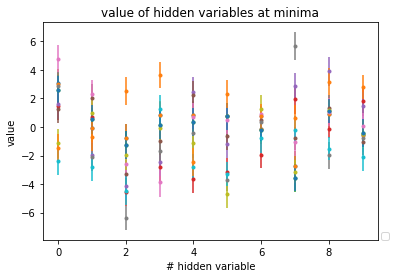

In [0]:
varis=np.asarray(varis)
map_minima=np.asarray(map_minima)
plt.figure()
plt.title('value of hidden variables at minima')
for ii in range(len(map_minima)):
  print(map_minima.shape)
  yerr_= np.sqrt(varis[ii,0])
  plt.errorbar(np.arange(hidden_size),np.squeeze(map_minima[ii]), yerr=yerr_, ls='', marker='.')
plt.legend(ncol=4, loc=(1.01,0))
plt.xlabel('# hidden variable')
plt.ylabel('value')
plt.show()

0
3909.2854
2912.962
2912.8591
2912.8481
2912.8425
2912.8333
2912.8623
2912.834
2912.831
2912.8303
1
7179.901
4163.7217
3812.8481
3804.3901
3804.0654
3804.0605
3804.0542
3804.064
3804.0757
3804.082
2
5634.2354
3954.1897
3847.7527
3826.404
3825.7104
3825.702
3825.71
3825.7231
3825.7012
3825.7148
3
5038.154
3984.1577
3979.6611
3979.5898
3979.6345
3979.5986
3979.6445
3979.7244
3979.6194
3979.5867
4
4830.8804
3939.3665
3932.6758
3932.5977
3932.591
3932.591
3932.5767
3932.594
3932.577
3932.6152
5
4499.8657
3035.0005
2859.436
2802.923
2798.6843
2798.6863
2798.6843
2798.6875
2798.6904
2798.687
6
4573.128
2978.2498
2932.5034
2932.248
2932.2412
2932.2327
2932.2405
2932.2324
2932.254
2932.236
7
5477.032
4033.145
4008.038
4008.0247
4008.028
4008.038
4008.0508
4008.0278
4008.0432
4008.0667
8
5304.25
3462.7974
3445.2554
3426.4714
3425.4297
3425.4285
3425.4292
3425.4316
3425.4402
3425.4316
9
4592.221
3963.7334
3952.3318
3952.2131
3952.2349
3952.2163
3952.2192
3952.236
3952.2158
3952.216


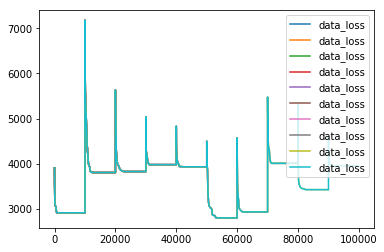

In [0]:
l_minima_old=[]
map_minima_old=[]
posterior_loss3=[]
for ii in range(10):
  print(ii)
  ini = np.random.randn((batch_size_2*hidden_size)).reshape((batch_size_2,hidden_size))
  sess.run(MAP_reset,feed_dict={x_re: data, MAP_ini:ini, nvp_prior: False, sigma_corr:sigma_new})
  lrate=1e-1
  for ii in range(3000):
    _, ll = sess.run([opt_op2,loss_MAP],feed_dict={x_re: data, nvp_prior: False, sigma_corr:sigma_new, lr:lrate})
    posterior_loss3.append(ll)
    if ii%1000==0:
      print(ll)
  lrate=1e-2
  for ii in range(5000):
    _, ll = sess.run([opt_op2,loss_MAP],feed_dict={x_re: data, nvp_prior: False, sigma_corr:sigma_new, lr:lrate})
    posterior_loss3.append(ll)
    if ii%1000==0:
      print(ll)
  lrate=1e-4
  for ii in range(2000):
    _, ll = sess.run([opt_op2,loss_MAP],feed_dict={x_re: data, nvp_prior: False, sigma_corr:sigma_new, lr:lrate})
    posterior_loss3.append(ll)
    if ii%1000==0:
      print(ll)
  l_minima_old+=[ll]
  map_minima_old+=[sess.run([MAP],feed_dict={x_re: data, sigma_corr:sigma_new, nvp_prior: False, lr:lrate})]
  plot(posterior_loss3,label='data_loss')
  legend()

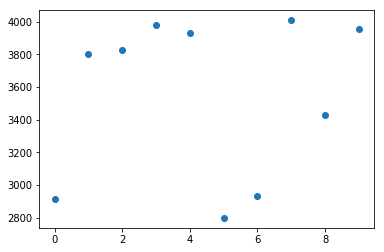

In [0]:
plt.figure()
plt.plot(np.arange(10),l_minima_old,ls='',marker='o')
plt.show()

In [0]:
import pickle
pickle.dump([l_minima_old,map_minima_old],open(minima_path+'minima.pkl','wb'))
l_minima_old,map_minima_old = pickle.load(open(minima_path+'minima.pkl','rb'))

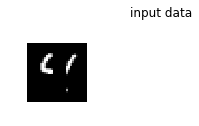

[5 0 6 8 1 2 4 9 3 7]


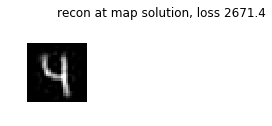

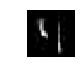

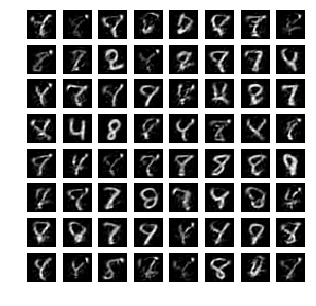

<Figure size 360x360 with 0 Axes>

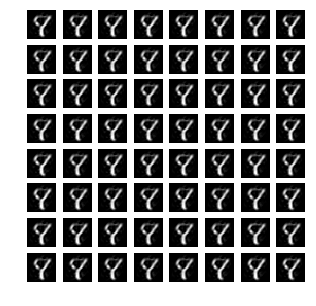

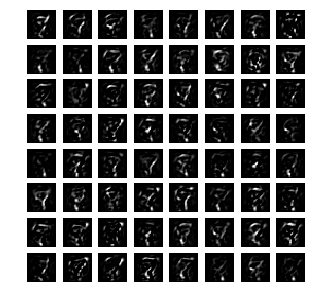

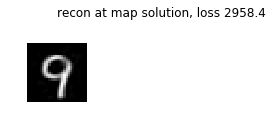

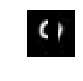

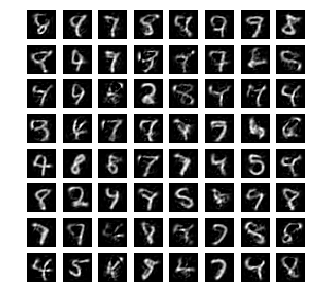

<Figure size 360x360 with 0 Axes>

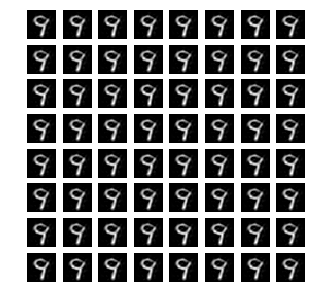

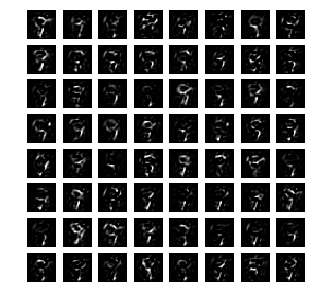

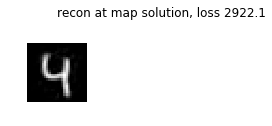

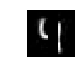

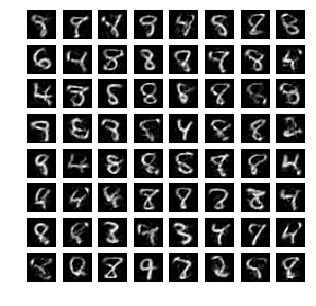

<Figure size 360x360 with 0 Axes>

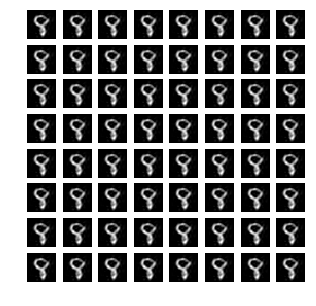

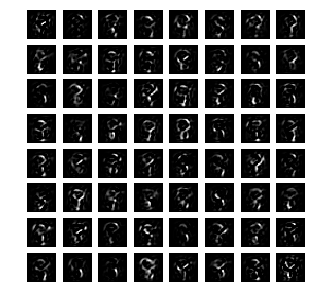

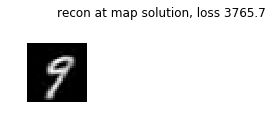

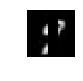

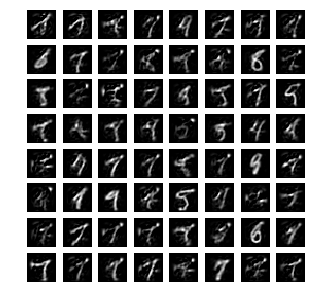

<Figure size 360x360 with 0 Axes>

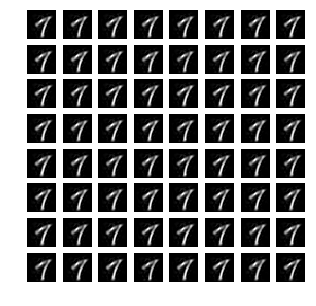

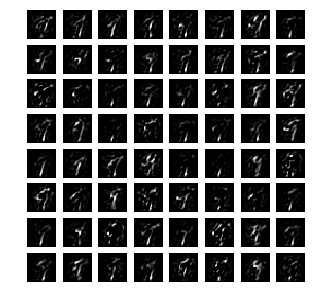

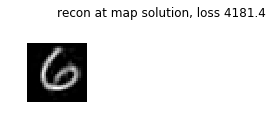

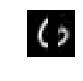

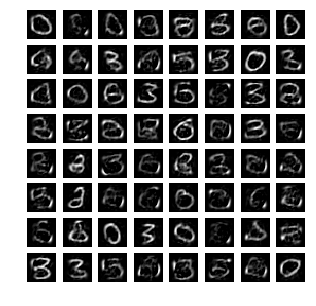

<Figure size 360x360 with 0 Axes>

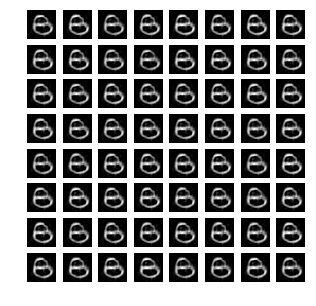

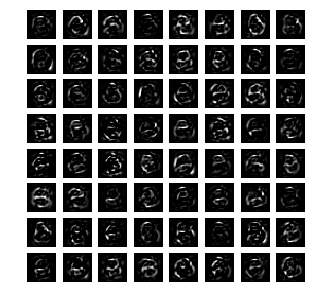

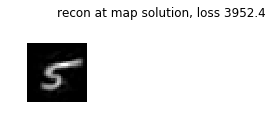

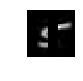

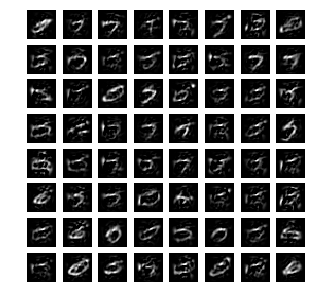

<Figure size 360x360 with 0 Axes>

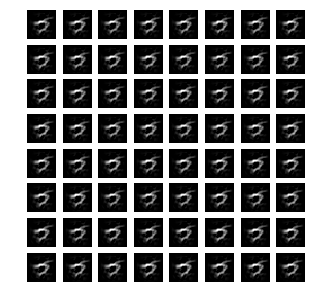

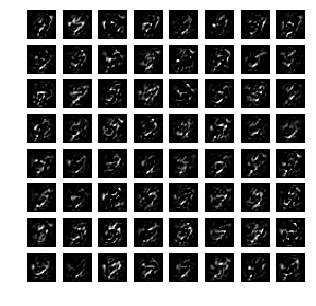

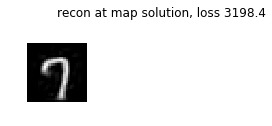

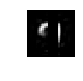

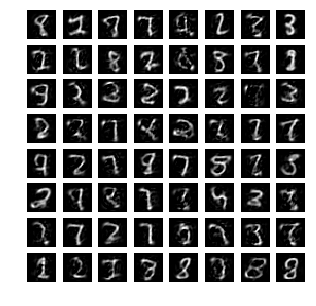

<Figure size 360x360 with 0 Axes>

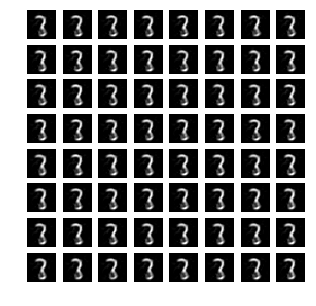

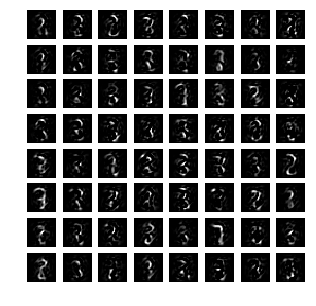

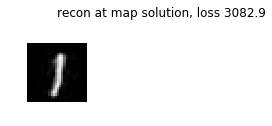

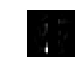

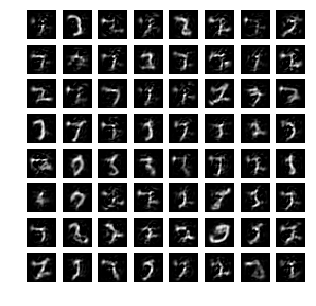

<Figure size 360x360 with 0 Axes>

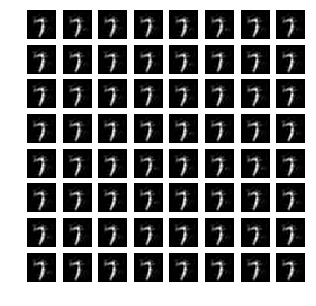

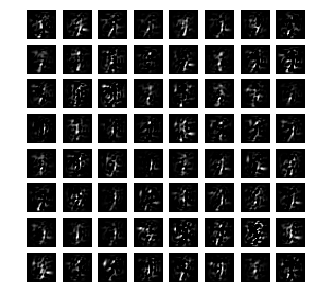

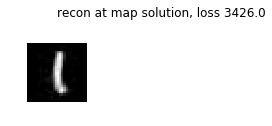

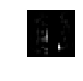

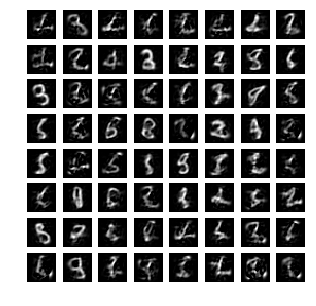

<Figure size 360x360 with 0 Axes>

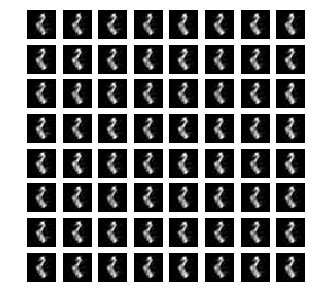

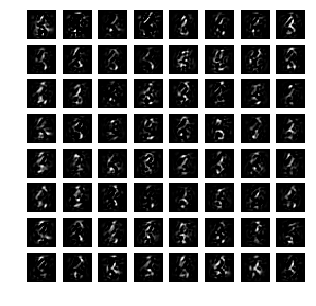

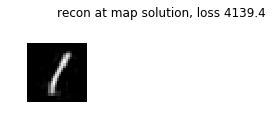

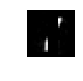

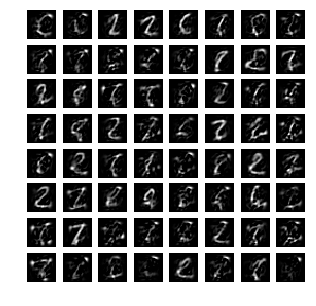

<Figure size 360x360 with 0 Axes>

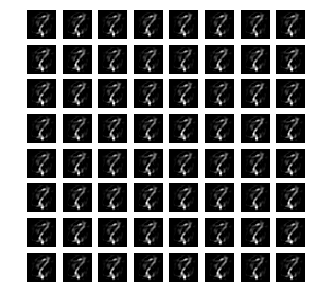

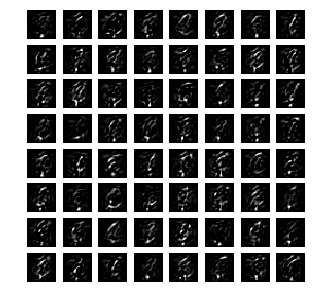

In [0]:
figure(figsize=(5,5))
suptitle('input data')
for i in range(min(batch_size_2,16)):
    subplot(4,4,i+1)
    imshow(np.reshape(data[i,:],(28,28)),cmap='gray',vmin=0)
    axis('off')
plt.show()

varis=[] 
l_minima_old=np.asarray(l_minima_old)
map_minima_old=np.asarray(map_minima_old)
order = np.argsort(l_minima_old)
print(order)
for ii,ini_ in enumerate(map_minima_old[order]):
  _ = sess.run(MAP_reset,feed_dict={x_re: data, MAP_ini:ini_[0], sigma_corr:sigma_new, nvp_prior:False})
  mean_at_map = sess.run(MAP_mean,feed_dict={x_re: data, sigma_corr:sigma_new})
  figure(figsize=(5,5))
  suptitle('recon at map solution, loss %.1f'%l_minima[ii])
  for i in range(min(batch_size_2,16)):
      subplot(4,4,i+1)
      imshow(np.reshape(mean_at_map[i,:,0],(28,28)),cmap='gray',vmin=0)
      axis('off')
      plt.show()
      subplot(4,4,i+1)
      imshow(np.reshape(mean_at_map[i,:,0]*mask[0,:,0],(28,28)),cmap='gray',vmin=0)
      axis('off')
  plt.show()
  _ = sess.run(MAP_reset,feed_dict={x_re: data, MAP_ini:ini_[0], sigma_corr:sigma_new, nvp_prior:False})
  mean_at_map = sess.run(MAP_mean,feed_dict={x_re: data, sigma_corr:sigma_new, nvp_prior:False})   
  _ = sess.run(update2,feed_dict={x_re: data, sigma_corr:sigma_new, nvp_prior:False})
#   eig1_, eig2_ = sess.run([eig1, eig2],feed_dict={x_re: data, sigma_corr:sigma_new, true_hess:False})
#   print(eig1_, 1./eig1_, eig2_)
  _ = sess.run(update3,feed_dict={x_re: data, sigma_corr:sigma_new, true_hess:False, nvp_prior:False})
  
  varis+=[sess.run(tf.linalg.diag_part(approx_posterior_laplace.covariance()),feed_dict={x_re: data, sigma_corr:sigma_new, true_hess:False, nvp_prior:False})]

  l_samples = sess.run(lap_mean,feed_dict={x_re: data, sigma_corr:sigma_new, true_hess:False, nvp_prior:False})
  figure(figsize=(5,5))
  suptitle('samples from Laplace apprpoximation, hessian: 1+ grad g x grad g/ sigma^2')
  for i in range(sample_size_z):
      subplot(8,8,i+1)
      imshow(np.reshape(l_samples[i,:,0],(28,28)),cmap='gray',vmin=0)
      axis('off')
  plt.show()
  figure(figsize=(5,5))
  mean_sample= np.reshape(np.mean(l_samples[:,:,0],axis=0),(28,28))
#   for i in range(sample_size_z):
#     subplot(8,8,i+1)
#     imshow(np.reshape(l_samples[i,:,0],(28,28))-mean_sample,cmap='gray',vmin=0)
#     axis('off')    
#   plt.show()
    
  try:
    _ = sess.run(update3,feed_dict={x_re: data, sigma_corr:sigma_new, true_hess:True, nvp_prior:False})

    l_samples = sess.run(lap_mean,feed_dict={x_re: data, sigma_corr:sigma_new, true_hess:True, nvp_prior:False})
    suptitle('samples from Laplace apprpoximation, full hessian')
    figure(figsize=(5,5))
    for i in range(sample_size_z):
        subplot(8,8,i+1)
        imshow(np.reshape(l_samples[i,:,0],(28,28)),cmap='gray',vmin=0)
        axis('off')
    plt.show()
    figure(figsize=(5,5))
    mean_sample= np.reshape(np.mean(l_samples[:,:,0],axis=0),(28,28))
    for i in range(sample_size_z):
      suptitle('subtracting the mean')
      subplot(8,8,i+1)
      imshow(np.reshape(l_samples[i,:,0],(28,28))-mean_sample,cmap='gray',vmin=0)
      axis('off')  
    plt.show()
  except:
    try:
      print('full hessian fails')
      print(sess.run([eig1, eig2],feed_dict={x_re: data, sigma_corr:sigma_new, true_hess:True, nvp_prior:False}))
    except:
      print('eigen decomp fails')


    


W0505 20:45:53.899823 140256009533312 legend.py:1289] No handles with labels found to put in legend.


(10, 1, 1, 10)
(10, 1, 1, 10)
(10, 1, 1, 10)
(10, 1, 1, 10)
(10, 1, 1, 10)
(10, 1, 1, 10)
(10, 1, 1, 10)
(10, 1, 1, 10)
(10, 1, 1, 10)
(10, 1, 1, 10)


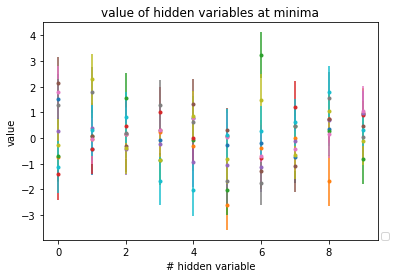

In [0]:
varis=np.asarray(varis)
map_minima_old=np.asarray(map_minima_old)
plt.figure()
plt.title('value of hidden variables at minima')
for ii in range(len(map_minima_old)):
  print(map_minima_old.shape)
  yerr_= np.sqrt(varis[ii,0])
  plt.errorbar(np.arange(hidden_size),np.squeeze(map_minima_old[ii]), yerr=yerr_, ls='', marker='.')
plt.legend(ncol=4, loc=(1.01,0))
plt.xlabel('# hidden variable')
plt.ylabel('value')
plt.show()